In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.version

'3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:59:51) \n[GCC 9.4.0]'

In [3]:
from cbf_opt import asif, cbf, dynamics
from cbf_hjr import cbf as cbf_hjr, dynamics as dynamics_hjr
import matplotlib.pyplot as plt
import hj_reachability as hj
import jax.numpy as jnp

In [4]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '28',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
import matplotlib.animation as anim

In [5]:
class ACC_Dynamics(dynamics.ControlAffineDynamics):

    
    def __init__(self, params, **kwargs):
        
        params['n_dims'] = 3
        params['control_dims'] = 1  # TODO: How to do this correctly?
        
        self.mass = params["mass"]
        self.g = params["g"]
        self.f0 = params["f0"]
        self.f1 = params["f1"]
        self.f2 = params["f2"]
        self.rolling_resistance = lambda x: self.f0 + self.f1 * x[1] + self.f2 * x[1] ** 2
        self.v0 = params["v0"]

        super().__init__(params, **kwargs)

    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([state[1], -1 / self.mass * self.rolling_resistance(state), self.v0 - state[1]])

    def control_matrix(self, state, time=0.0):
        return jnp.expand_dims(jnp.array([0, 1 / self.mass, 0]), axis=-1)

    def disturbance_jacobian(self, state, time=0.0):
        return jnp.expand_dims(jnp.zeros(3), axis=-1)

In [27]:
class ACC_CBF(cbf.ControlAffineCBF):
    def __init__(self, dynamics, params, **kwargs):
        super().__init__(dynamics, params, **kwargs)
        self.Th = params["Th"]
        self.cd = params["cd"]

    def vf(self, state, time=0.0):
        return state[2] - self.Th * state[1] - (state[1] - self.dynamics.v0) ** 2 / (2 * self.cd * self.dynamics.g)

    def vf_dt_partial(self, state, time=0.0):
        return 0.0
    
    def _grad_vf(self, state, time=0.0):
        return np.array([0.0, -self.Th * (state[1] - self.dynamics.v0) / (self.cd * self.dynamics.g), 1.0])

In [7]:
params = dict()
params["n_dims"] = 3
params["control_dims"] = 1
params["dt"] = 0.01
params["g"] = 9.81
params['v0'] = 14  # lead vehicle velocity
params['f0'] = 0.1  # friction coefficient
params['f1'] = 5  # friction coefficient
params['f2'] = 0.25  # friction coefficient
params['mass'] = 1650  # vehicle mass

acc = ACC_Dynamics(params)

In [8]:
cbf_params = dict()
cbf_params["cd"] = 0.3
cbf_params["Th"] = 1.8
acc_cbf = ACC_CBF(acc, cbf_params)

In [9]:
umax = cbf_params['cd'] * params['mass'] * params['g']
umin = -umax

## Offline: Warmstarting reachability with a *candidate* CBF

In [10]:
dyn_reachability = dynamics_hjr.HJControlAffineDynamics(acc, control_space=hj.sets.Box(jnp.array([umin]), jnp.array([umax])))

In [11]:
low_bound = jnp.array([0., 10., 0.])
high_bound = jnp.array([1e3, 40., 100.])
nbr_pts = (51, 101, 101)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(low_bound, high_bound), nbr_pts)

acc_tabular_cbf = cbf_hjr.TabularCBF(acc, grid)

In [12]:
acc_tabular_cbf.tabularize_cbf(acc_cbf)

100%|██████████| 51/51 [00:02<00:00, 20.62it/s]


In [13]:
acc_tabular_cbf.vf_table.shape

(51, 101, 101)

Text(0, 0.5, 'Distance to vehicle')

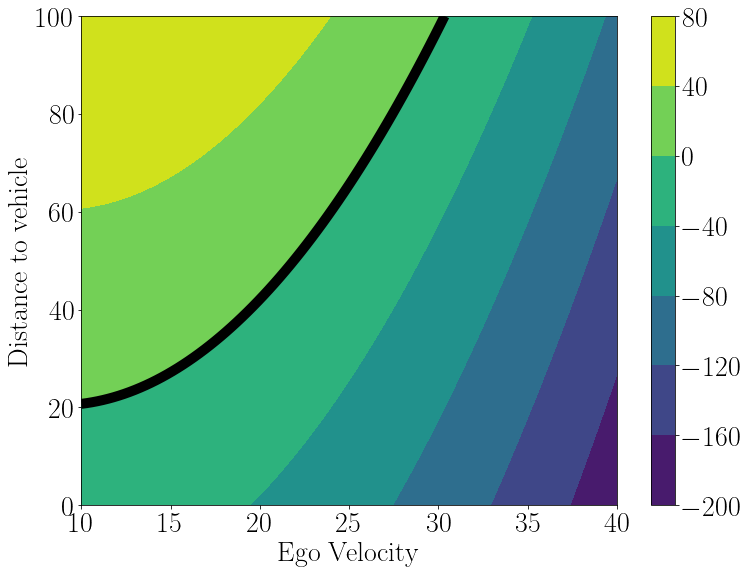

In [14]:
fig, ax = plt.subplots(figsize=(12, 9))
c = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2],
 acc_tabular_cbf.vf_table[0, ...].T)
ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], acc_tabular_cbf.vf_table[0, ...].T, levels=[0.0], colors='k', linewidths=10)
fig.colorbar(c)
ax.set_xlabel("Ego Velocity")
ax.set_ylabel("Distance to vehicle")

In [15]:
init_value = acc_tabular_cbf.vf_table
obstacle = grid.states[..., 2] - acc_cbf.Th * grid.states[..., 1]
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("medium",
                                                  value_postprocessor=backwards_reachable_tube(obstacle))

In [16]:
time = 0.
target_time = -20.0
times = jnp.linspace(time, target_time, 101)
target_values = hj.solve(solver_settings, dyn_reachability, grid, times, init_value)

100%|##########| 20.0000/20.0 [03:16<00:00,  9.82s/sim_s]


In [17]:
time = 0.
target_time = -20.0
times = jnp.linspace(time, target_time, 101)
target_values_hjr = hj.solve(solver_settings, dyn_reachability, grid, times, obstacle)

100%|##########| 20.0000/20.0 [02:42<00:00,  8.11s/sim_s]


Text(0, 0.5, 'Distance to vehicle')

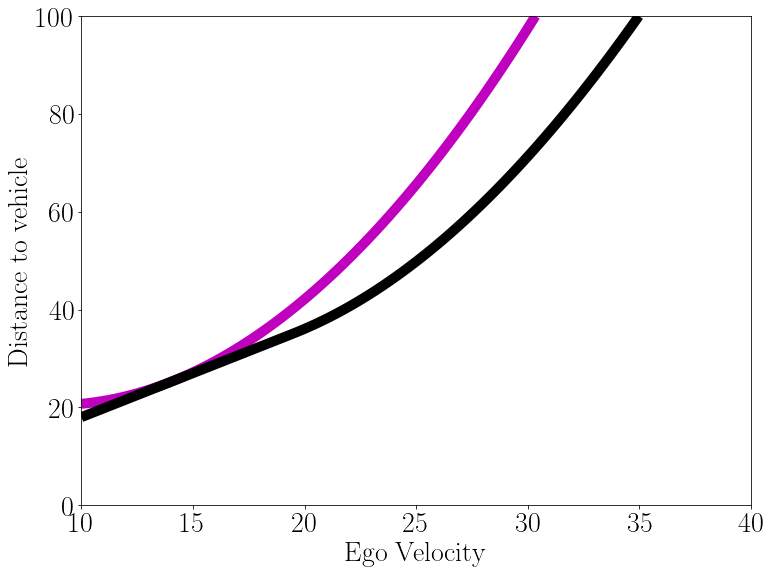

In [19]:
idx = 101
fig, ax = plt.subplots(figsize=(12, 9))
# c = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values[idx][0].T)
ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], acc_tabular_cbf.vf_table[0, ...].T, levels=[0.0], colors='m', linewidths=10)
ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values[idx][0].T, levels=[0.0], colors='k', linewidths=10)
ax.set_xlabel("Ego Velocity")
ax.set_ylabel("Distance to vehicle")

In [20]:
def render_frame(i, colorbar=False):
    global cont
    for c in cont.collections:
        c.remove()
        
    cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], value_function[i][0].T, levels=[0], colors='g')

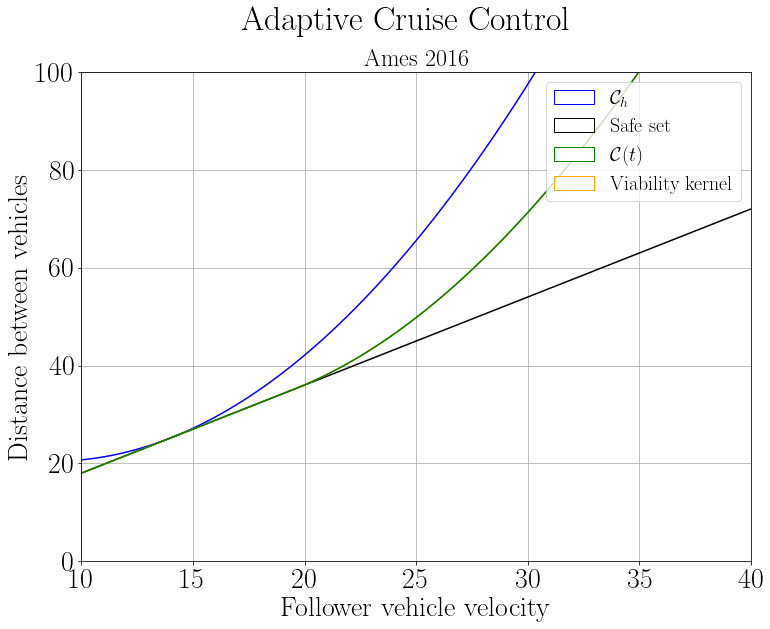

In [21]:
value_function = target_values
filename="acc_cbf.mp4"
proxy = [] 

fig, ax = plt.subplots(figsize=(12, 9))
cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], acc_tabular_cbf.vf_table[0, ...].T, levels=[0], colors='b')
proxy += [plt.Rectangle((0,0),1,1,ec = 'b', fc='white') 
        for pc in cs.collections]

cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], obstacle[0].T, levels=[0], colors='k')
proxy += [plt.Rectangle((0,0),1,1,ec = 'k', fc='white') for pc in cs.collections]

cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], value_function[0][0].T, levels=[0], colors='g')
proxy += [plt.Rectangle((0,0),1,1,ec = 'g', fc='white')
        for pc in cont.collections]
cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], value_function[-1][0].T, levels=[0], colors='orange')
proxy += [plt.Rectangle((0,0),1,1,ec = 'orange', fc='white')
        for pc in cs.collections]
ax.grid()

ax.legend(proxy, ["$\mathcal{C}_{h}$", "Safe set", "$\mathcal{C}(t)$", "Viability kernel"], prop={'size': 20})

ax.set_ylabel("Distance between vehicles")
ax.set_xlabel("Follower vehicle velocity")


ax.set_title("Ames 2016", fontsize=24)
fig.suptitle("Adaptive Cruise Control")
render_frame(0, False)
animation = anim.FuncAnimation(fig, render_frame, value_function.shape[0], interval=50)
animation.save(filename, writer='ffmpeg', fps=30)

Text(0, 0.5, 'Distance to vehicle')

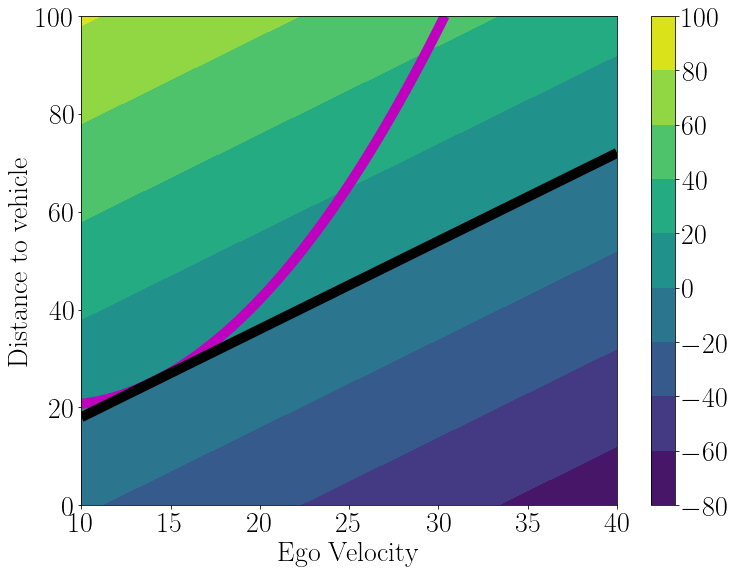

In [22]:
idx = 0
fig, ax = plt.subplots(figsize=(12, 9))
c = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_hjr[idx][0].T)
ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], acc_tabular_cbf.vf_table[0, ...].T, levels=[0.0], colors='m', linewidths=10)
ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_hjr[idx][0].T, levels=[0.0], colors='k', linewidths=10)
fig.colorbar(c)
ax.set_xlabel("Ego Velocity")
ax.set_ylabel("Distance to vehicle")

## Online: Enforcing the CBF condition (Comparison)

In [23]:
import numpy as np

In [24]:
vd = 24

alpha = lambda x: 5 * x
nominal_policy = lambda x, t: np.atleast_1d(np.clip(-1000 * (x[1] - vd), umin, umax))
acc_asif = asif.ControlAffineASIF(acc, acc_cbf, alpha=alpha, nominal_policy=nominal_policy)

TODO: Make simulating dynamics much more straightforward -> See e.g. Dawson

In [30]:
x0 = np.array([0, 30, 100])
states = [x0]
control = []
control_filt = []
control_filt_gen = []
x_filt = x0 
betas = []
states_filt = [x0]
x_filt_gen = x0
states_filt_gen = [x0]

ts = np.arange(0, 20, params['dt'])

x = x0
for t in ts:  
    input_nom = nominal_policy(x, t)
    x = acc.step(x, input_nom)
    states.append(x)
    control.append(input_nom)

for t in ts:
    input_mod = np.atleast_1d(np.clip(acc_asif(x_filt), umin, umax))

    x_filt = np.array(acc.step(x_filt, input_mod))
    states_filt.append(x_filt)
    control_filt.append(input_mod)

/home/tonkens/anaconda3/envs/cbf_hjr/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


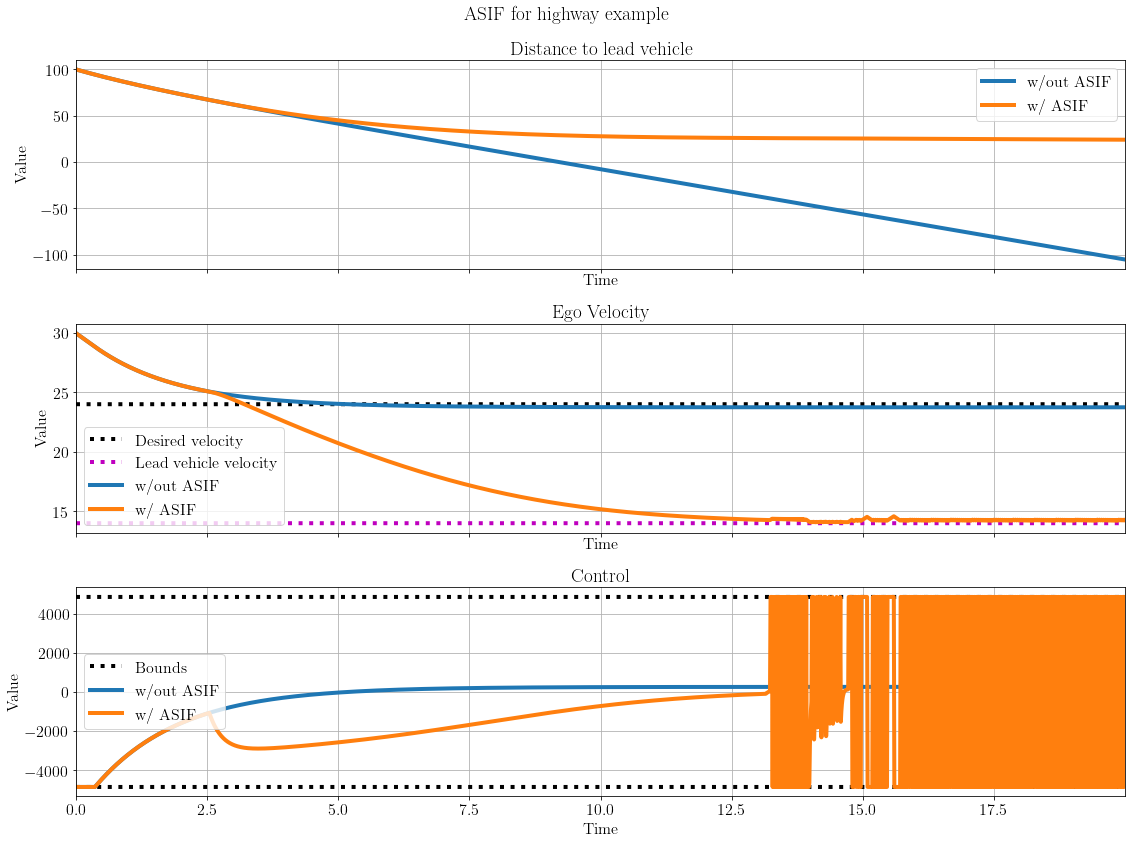

In [ ]:
states = np.array(states)
states_filt = np.array(states_filt)
states_filt_gen = np.array(states_filt_gen)

ts = np.arange(0, 20, params['dt'])
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(16, 12))
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = 4
fig.suptitle("ASIF for highway example")
ax[0].set_title("Distance to lead vehicle")
ax[0].plot(ts[:states.shape[0]-1], states[1:,2], label='w/out ASIF')
ax[0].plot(ts[:states_filt.shape[0]-1], states_filt[1:,2], label='w/ ASIF')

ax[0].legend()
ax[1].set_title("Ego Velocity")
ax[1].plot(ts, vd * np.ones_like(ts), ':k', label='Desired velocity')
ax[1].plot(ts, params['v0'] * np.ones_like(ts), ':m', label='Lead vehicle velocity')
ax[1].plot(ts[:states.shape[0]-1], states[1:,1], label='w/out ASIF')
ax[1].plot(ts[:states_filt.shape[0]-1], states_filt[1:,1], label='w/ ASIF')

ax[1].legend()
ax[2].set_title("Control")
ax[2].plot(ts, np.ones_like(ts) * umax, ':k', label='Bounds')
ax[2].plot(ts, np.ones_like(ts) * umin, ':k', label='__nolegend__')
ax[2].plot(ts[:len(control)], control, label='w/out ASIF')
ax[2].plot(ts[:len(control_filt)], control_filt, label='w/ ASIF')

ax[2].legend()
for axi in ax:
    axi.grid()
    axi.set_xlabel("Time")
    axi.set_ylabel("Value")
    axi.set_xlim([ts[0], ts[-1]])
fig.tight_layout()
